In [130]:
library(coda)
library(ggplot2)
library(dplyr)
library(tidyr)

In [131]:
tmp <- NULL
for (m in 1:8){
url <- paste0('http://www2.stat.duke.edu/~pdh10/FCBS/Exercises/school', m,'.dat')
tmp2 <- read.table(file = url, header = T)
names(tmp2) <- 'grades'
tmp <- rbind(tmp, cbind(school = rep(m,length(tmp2)), grades = tmp2 ))
}
Y <- data.frame(school = factor(tmp[,1]), hours= tmp[,2])

In [132]:
head(Y)


,school,hours
,<fct>,<dbl>
1,1,9.75
2,1,13.88
3,1,11.30
4,1,8.93
5,1,15.66
6,1,16.38


### a

In [133]:
J        <- length(unique(Y$school))
schools  <- sort(unique(Y$school))

Y_list   <- split(Y$hours, Y$school)
n_j      <- sapply(Y_list, length)
ybar_j   <- sapply(Y_list, mean)
N_total  <- sum(n_j)

In [134]:
n_j

1  2  3  4  5  6  7  8 
24 22 19 23 23 21 21 19

In [135]:
ybar_j

1         2         3         4         5         6         7         8 
 9.770417  7.340000  8.143684  5.961304 10.670000  6.381429  6.067619  7.432105

priors

In [136]:
mu0       <- 7
gamma0_2  <- 5      # γ0^2
tau0_2    <- 10     # τ0^2
eta0      <- 2
sigma0_2  <- 15     # σ0^2
nu0       <- 2

MCMC results

In [137]:
S        <- 5000              # total iterations
theta    <- matrix(NA, S, J)   # school means θ_j
mu       <- numeric(S)
tau2     <- numeric(S)
sigma2   <- numeric(S)

Initital values

In [138]:
theta[1, ] <- ybar_j
mu[1]      <- mean(ybar_j)
tau2[1]    <- var(ybar_j)
sigma2[1]  <- var(Y$hours)

In [139]:
rinvchisq <- function(n, df, scale) df * scale / rchisq(n, df)

In [140]:
for (s in 2:S) {

  ## 1. update mu
  V_mu <- 1 / (J / tau2[s-1] + 1 / gamma0_2)
  m_mu <- V_mu * (sum(theta[s-1, ]) / tau2[s-1] + mu0 / gamma0_2)
  mu[s] <- rnorm(1, mean = m_mu, sd = sqrt(V_mu))

  ## 2. update tau
  SSR_theta <- sum((theta[s-1, ] - mu[s])^2)
  df_tau    <- eta0 + J
  scale_tau <- (eta0 * tau0_2 + SSR_theta) / df_tau
  tau2[s]   <- rinvchisq(1, df = df_tau, scale = scale_tau)

  ## 3. update sigma
  SSE <- 0
  for (j in 1:J) {
    SSE <- SSE + sum((Y_list[[j]] - theta[s-1, j])^2)
  }
  df_sig    <- nu0 + N_total
  scale_sig <- (nu0 * sigma0_2 + SSE) / df_sig
  sigma2[s] <- rinvchisq(1, df = df_sig, scale = scale_sig)

  ## 4. update theta
  for (j in 1:J) {
    V_j <- 1 / (n_j[j] / sigma2[s] + 1 / tau2[s])
    m_j <- V_j * (n_j[j] * ybar_j[j] / sigma2[s] + mu[s] / tau2[s])
    theta[s, j] <- rnorm(1, mean = m_j, sd = sqrt(V_j))
  }
}

In [141]:
effectiveSize(mu)
effectiveSize(tau2)
effectiveSize(sigma2)
apply(theta, 2, effectiveSize)

var1 
3977.117

var1 
3892.493

var1 
4489.019

[1] 4256.179 5000.000 5000.000 4413.716 4350.298 4718.267 4597.042 5000.000

In [142]:
hyper_df <- tibble(
  mu     = mu,
  tau2   = tau2,
  sigma2 = sigma2
) %>% mutate(iter = row_number())

In [143]:
head(hyper_df)

mu,tau2,sigma2,iter
<dbl>,<dbl>,<dbl>,<int>
7.720820,2.989806,16.13698,1
7.570550,6.628898,12.10141,2
6.736584,5.207927,14.81025,3
8.546359,4.563235,13.50521,4
7.428090,4.209582,16.21629,5
8.349309,3.119054,14.07559,6


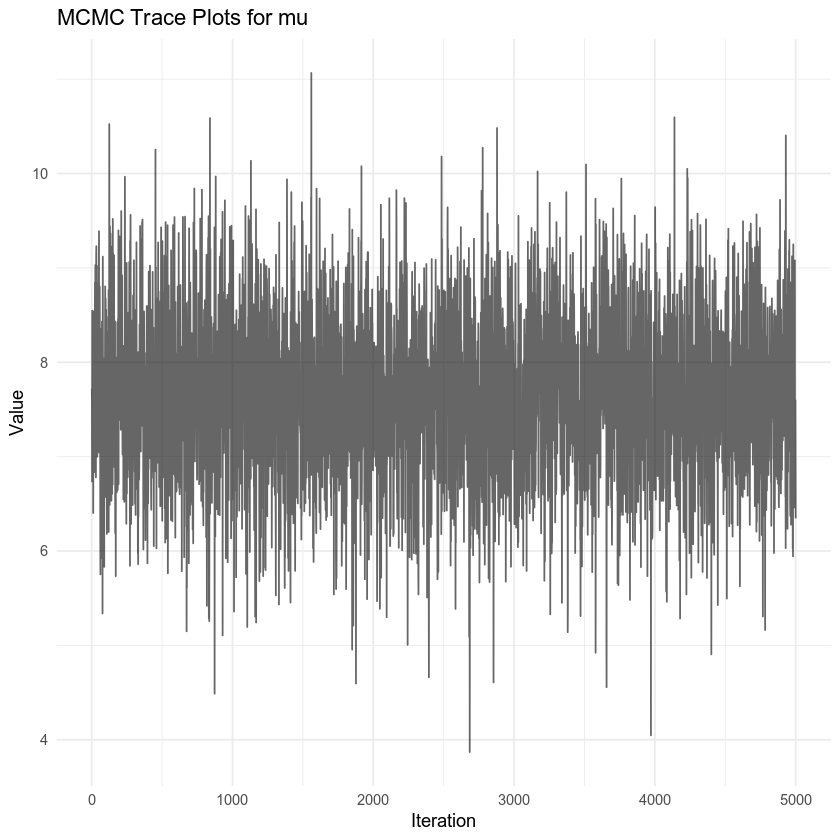

In [144]:
p <- ggplot(hyper_df, aes(x = iter, y = mu)) +
  geom_line(alpha = 0.6) +
  labs(x = "Iteration", y = "Value",
       title = "MCMC Trace Plots for mu") +
  theme_minimal()

p
ggsave("../Figures/Assignment_5/mu.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")

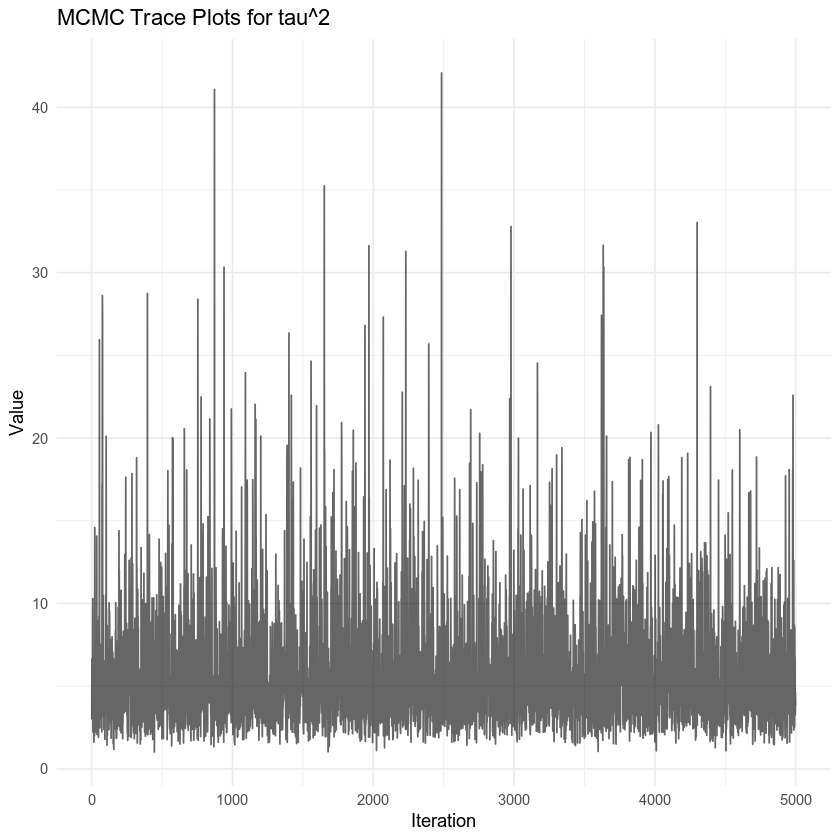

In [145]:
p <- ggplot(hyper_df, aes(x = iter, y = tau2)) +
  geom_line(alpha = 0.6) +
  labs(x = "Iteration", y = "Value",
       title = "MCMC Trace Plots for tau^2") +
  theme_minimal()

p
ggsave("../Figures/Assignment_5/tau.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")

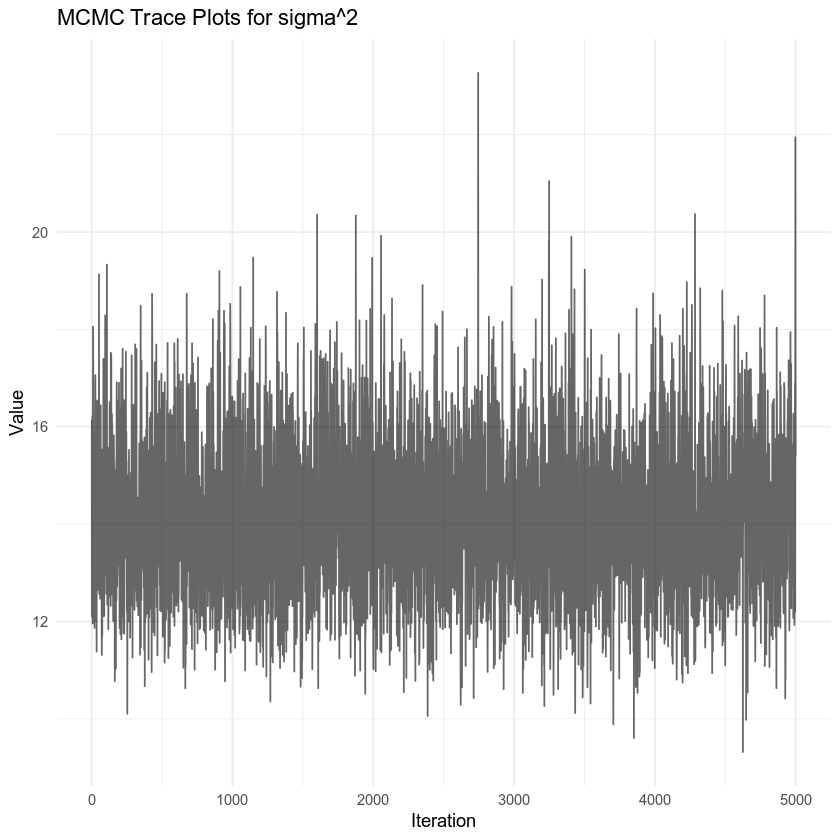

In [146]:
p <- ggplot(hyper_df, aes(x = iter, y = sigma2)) +
  geom_line(alpha = 0.6) +
  labs(x = "Iteration", y = "Value",
       title = "MCMC Trace Plots for sigma^2") +
  theme_minimal()

p
ggsave("../Figures/Assignment_5/sigma.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")

### b

In [147]:
n_prior <- nrow(hyper_df)

set.seed(1)
mu_prior     <- rnorm(n_prior, mean = mu0, sd = sqrt(gamma0_2))
tau2_prior   <- rinvchisq(n_prior, df = eta0, scale = tau0_2)
sigma2_prior <- rinvchisq(n_prior, df = nu0,  scale = sigma0_2)

In [148]:
prior_df <- tibble(
  mu     = mu_prior,
  tau2   = tau2_prior,
  sigma2 = sigma2_prior,
  iter   = NA_integer_,     # priors have no iteration number
  dist   = "Prior"
)

In [150]:
hyper_df <- hyper_df %>% 
    mutate(dist="Posterior") 

In [158]:
combined <- bind_rows(hyper_df, prior_df)

In [159]:
posterior_mean_mu     <- mean(mu)
posterior_mean_tau2   <- mean(tau2)
posterior_mean_sigma2 <- mean(sigma2)

posterior_mean_theta  <- colMeans(theta)

In [160]:
posterior_mean_mu     
posterior_mean_tau2   
posterior_mean_sigma2 
posterior_mean_theta  

[1] 7.648195

[1] 5.705193

[1] 14.09178

[1]  9.522194  7.389480  8.088136  6.165567 10.294427  6.535671  6.293946
[8]  7.473916

In [161]:
cred_mu     <- quantile(mu, c(0.025, 0.975))
cred_tau2   <- quantile(tau2, c(0.025, 0.975))
cred_sigma2 <- quantile(sigma2, c(0.025, 0.975))

cred_theta  <- apply(theta, 2, quantile, c(0.025, 0.975))

In [162]:
cred_mu 
cred_tau2
cred_sigma2
cred_theta

2.5%    97.5% 
5.978409 9.286545

2.5%    97.5% 
 1.88882 15.25161

2.5%    97.5% 
11.34561 17.41139

2.5%,8.062917,5.887254,6.492187,4.671615,8.823939,5.059783,4.783418,5.932874
97.5%,10.949105,8.864310,9.647641,7.612047,11.788748,8.038939,7.818109,9.017209


In [164]:
post_df <- combined %>%
  pivot_longer(
    cols = c(mu, tau2, sigma2),
    names_to = "parameter",
    values_to = "value"
  )

Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_density()`).”


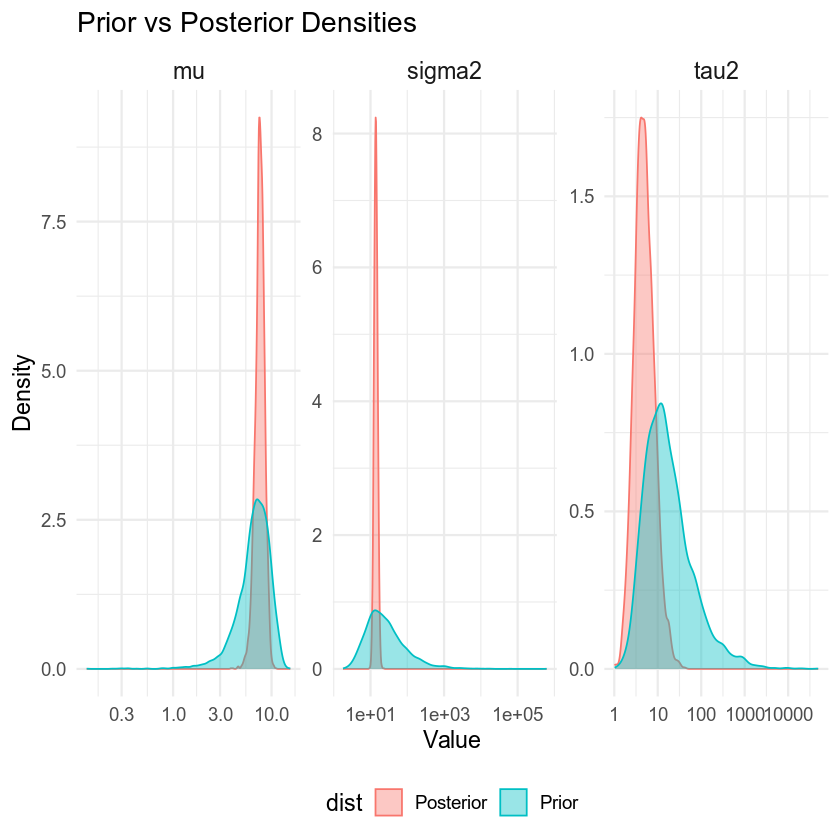

In [168]:
p <- ggplot(post_df, aes(x = value, fill = dist, color = dist)) +
  geom_density(alpha = 0.4) +
  facet_wrap(~ parameter, scales = "free", nrow = 1) +
  labs(title = "Prior vs Posterior Densities",
       x = "Value",
       y = "Density") +
  theme_minimal(base_size = 14) +
  scale_x_log10() +
  theme(
    legend.position = "bottom",
    strip.text = element_text(size = 14)
  )

p
ggsave("../Figures/Assignment_5/posterior_density.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")

In [179]:
R <- tau2 / sigma2 + tau2
R_prior <-tau2_prior / sigma2_prior + tau2_prior

R_df <- data.frame(
  dist  = c(rep("Prior R", length(R_prior)),
            rep("Posterior R", length(R))),
  value = c(R_prior, R)
)

In [184]:
head(R_df)

,dist,value
,<chr>,<dbl>
1,Prior R,3.860026
2,Prior R,8.577030
3,Prior R,22.559631
4,Prior R,2.985179
5,Prior R,33.645900
6,Prior R,4.660217


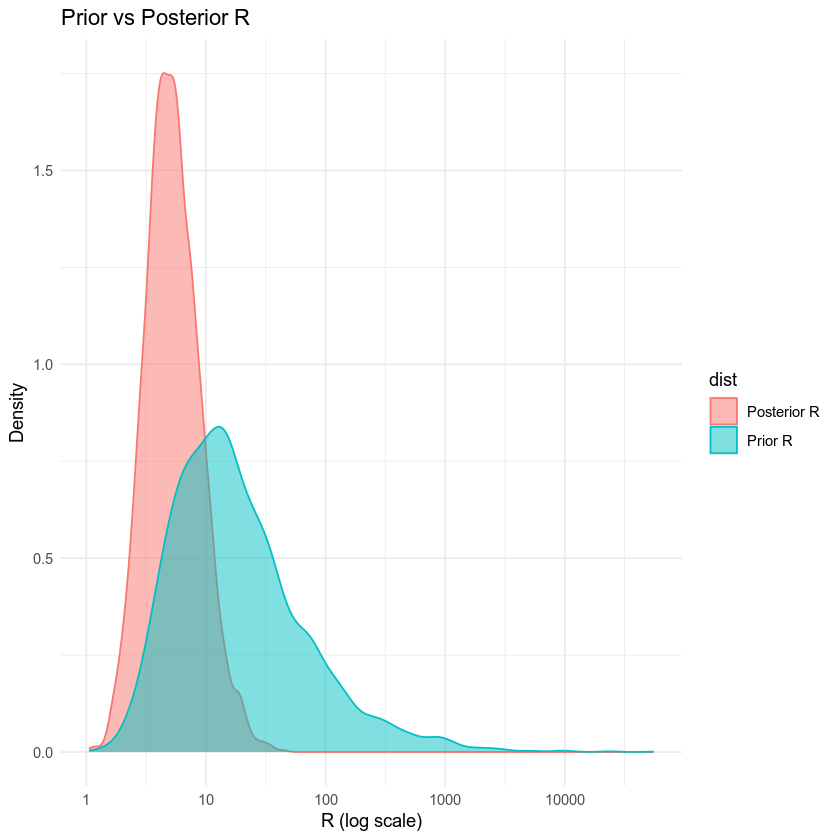

In [190]:
p <- ggplot(R_df, aes(x = value, fill = dist, color=dist)) +
  geom_density(alpha = 0.5) +
  scale_x_log10() +
  theme_minimal() +
  labs(title = "Prior vs Posterior R",
       x = "R (log scale)", y = "Density")

p
ggsave("../Figures/Assignment_5/R.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")

In [192]:
prob_theta7_lt_theta6 <- mean(theta[,7] < theta[,6])
prob_theta7_lt_theta6

[1] 0.592

In [193]:
min_index <- apply(theta, 1, which.min)

prob_theta7_is_smallest <- mean(min_index == 7)
prob_theta7_is_smallest

[1] 0.3302

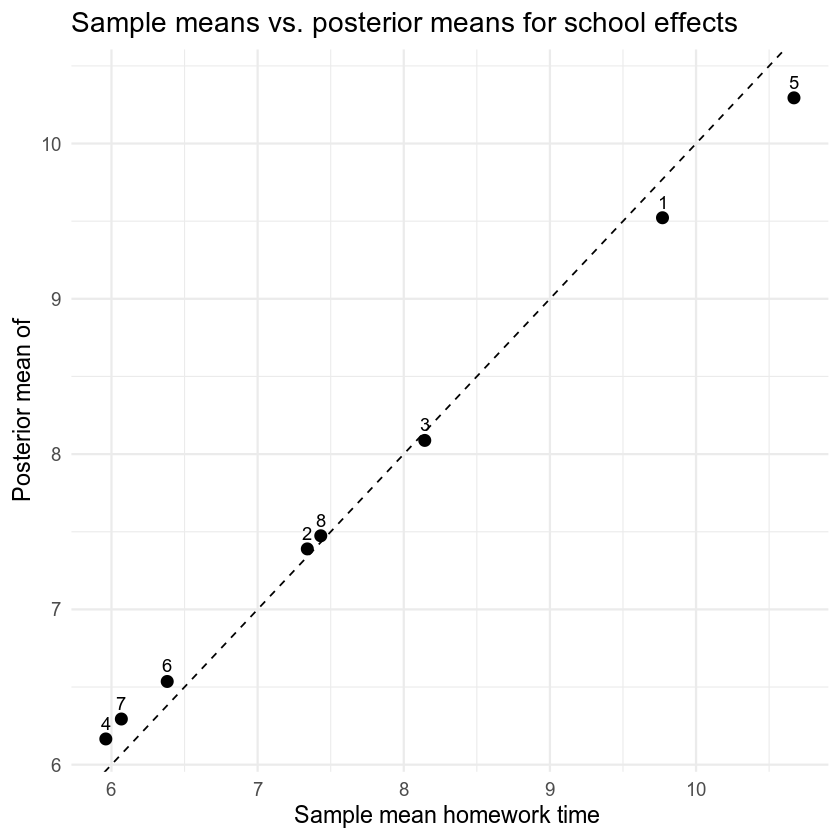

In [197]:
plot_df <- tibble(
  school   = factor(1:J),
  ybar     = ybar_j,
  thetahat = posterior_mean_theta
)

p <- ggplot(plot_df, aes(x = ybar, y = thetahat, label = school)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +  # line y = x
  geom_point(size = 3) +
  geom_text(nudge_y = 0.1) +
  labs(
    x = "Sample mean homework time ",
    y = "Posterior mean of",
    title = "Sample means vs. posterior means for school effects"
  ) +
  theme_minimal(base_size = 14)

p
ggsave("../Figures/Assignment_5/comp.png", plot = p, width = 7, height = 5, dpi = 300, bg = "white")

In [196]:
overall_mean <- mean(Y$hours)      # or mean(unlist(Y_list))
overall_mean
posterior_mean_mu  

[1] 7.766628

[1] 7.648195